In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16 , VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout ,Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab import files

In [ ]:
test_path = 'chest_xray/test'
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'

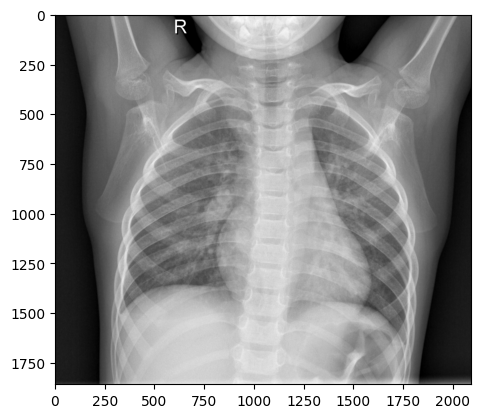

In [ ]:
img_path = 'chest_xray/train/NORMAL/IM-0115-0001.jpeg'
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

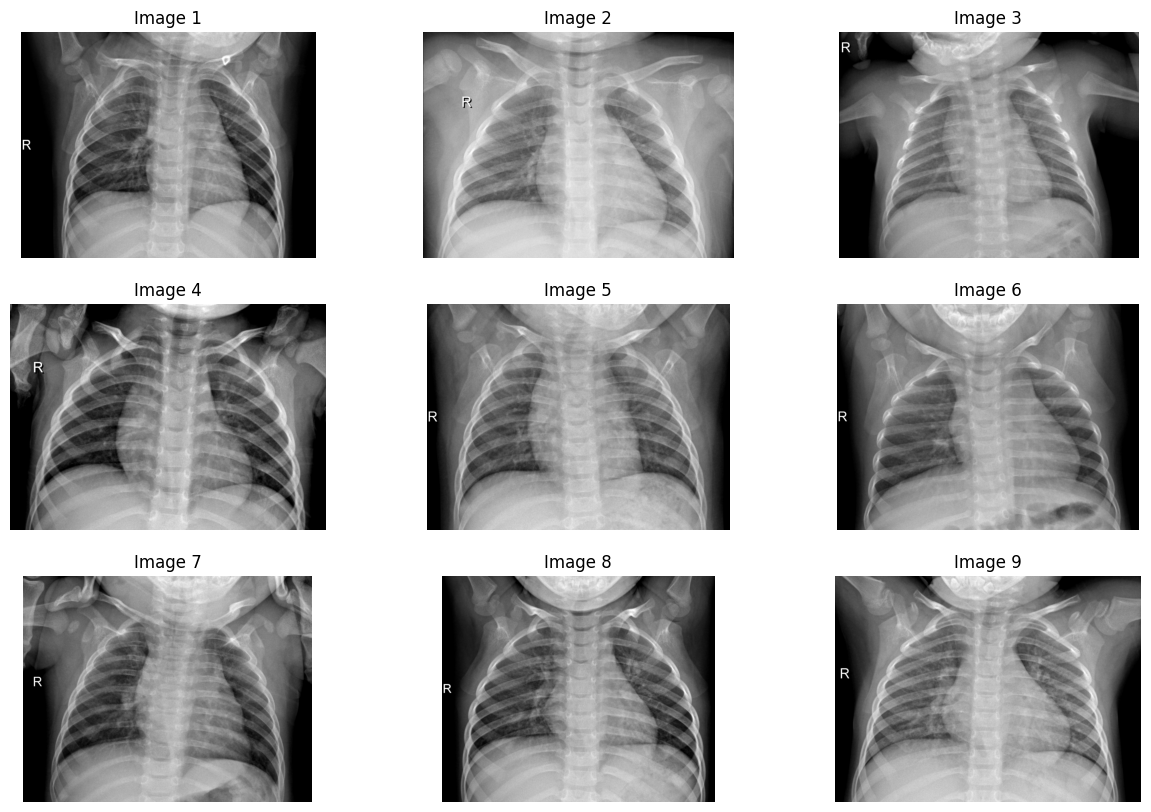

In [ ]:
dataset_path = 'chest_xray/train/NORMAL'

image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpeg')]

# Display a few images
plt.figure(figsize=(15, 10))
for i in range(9):
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()


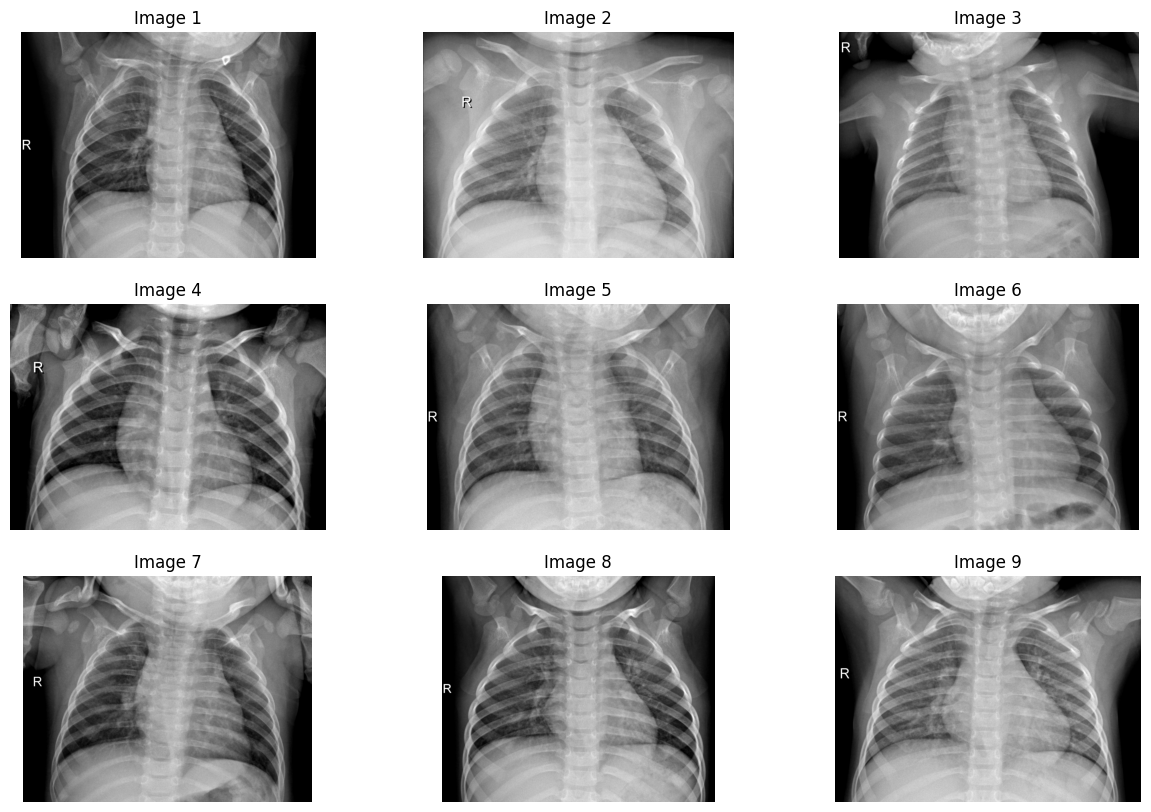

In [ ]:
# Define the path to the dataset
dataset_paths = 'chest_xray/train/PNEUMONIA'

# Get a list of image files
images_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpeg')]

# Display a few images
plt.figure(figsize=(15, 10))
for i in range(9):
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread(image_files[0])
print(f'Image size: {img.shape}')

Image size: (1164, 1512, 3)


In [ ]:
# Data augmentation and rescaling for training data
# TensorFlow is used to generate batches of image data with real-time data augmentation, which helps improve the generalization of the model.
train_datagen = ImageDataGenerator(
    #Neural networks usually work better when the input values are smaller, typically between 0 and 1
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation data
)

# Data augmentation and rescaling for validation and test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% validation data
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[early_stopping]

)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 119s 762ms/step - accuracy: 0.7919 - loss: 1.2625 - val_accuracy: 0.9561 - val_loss: 0.1360
Epoch 2/10
  1/130 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.9688 - loss: 0.0984

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.9688 - loss: 0.0984 - val_accuracy: 0.8947 - val_loss: 0.1894
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 148s 688ms/step - accuracy: 0.9385 - loss: 0.1587 - val_accuracy: 0.9492 - val_loss: 0.1160
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0539
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 696ms/step - accuracy: 0.9428 - loss: 0.1407 - val_accuracy: 0.9287 - val_loss: 0.1695
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.9375 - loss: 0.0951 - val_accuracy: 0.9474 - val_loss: 0.1779
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 714ms/step - accuracy: 0.9485 - loss: 0.1257 - val_accuracy: 0.9316 - val_loss: 0.1580


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 686ms/step - accuracy: 0.8503 - loss: 0.4610
Test Loss: 0.4256942570209503
Test Accuracy: 0.8525640964508057


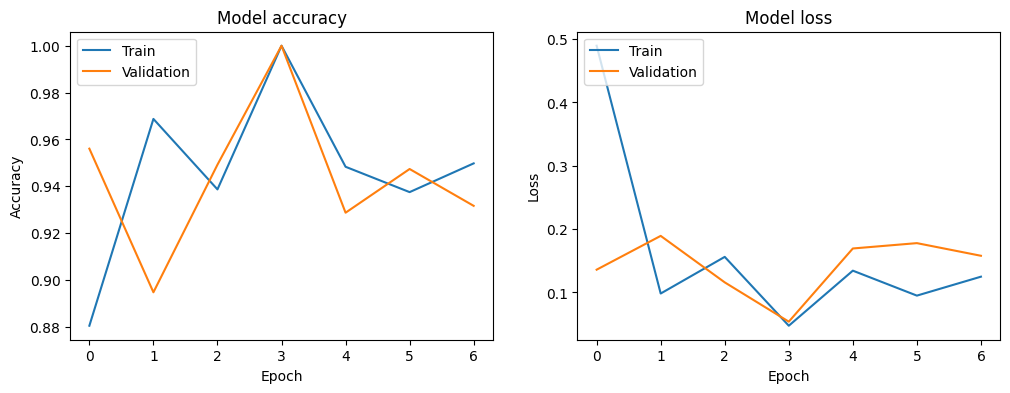

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
h = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 685ms/step - accuracy: 0.7786 - loss: 1.1357 - val_accuracy: 0.9141 - val_loss: 0.2058
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8125 - loss: 0.2835 - val_accuracy: 0.8947 - val_loss: 0.2148
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 90s 660ms/step - accuracy: 0.8971 - loss: 0.2628 - val_accuracy: 0.9199 - val_loss: 0.1853


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.7299 - loss: 0.7159
Test Loss: 0.622169017791748
Test Accuracy: 0.7756410241127014


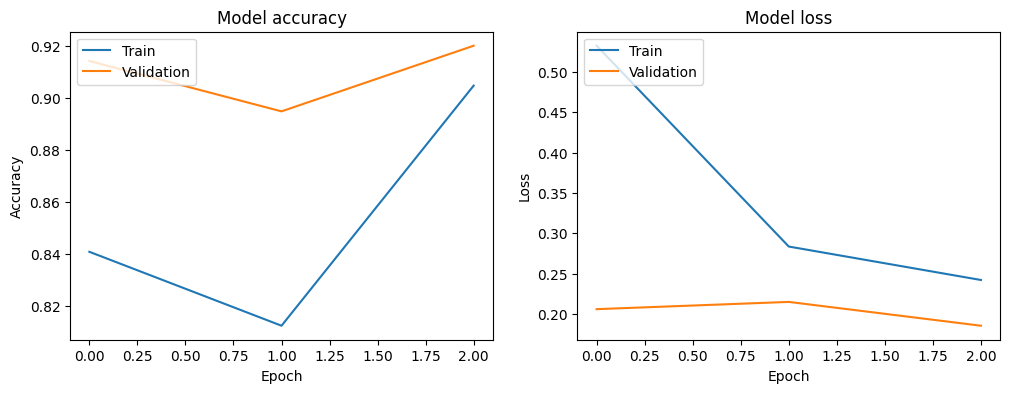

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()